In [246]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import pkg_resources
#pkg_resources.require("numpy==1.15.4")
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
#import fbprophet
!pip install --upgrade fbprophet


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

Requirement already up-to-date: fbprophet in /opt/conda/lib/python3.6/site-packages (0.4.post2)
['20180416_Dataset_Change_Notice_-_Police_Incidents.pdf', 'socrata_metadata_police-department-incidents.json', 'Radio Codes 2016.xlsx', 'police-department-calls-for-service.csv', 'socrata_metadata_police-department-calls-for-service.json', 'police-department-incidents.csv']


**Data Import**

In [247]:
calls_for_service = pd.read_csv('../input/police-department-calls-for-service.csv')
incidents = pd.read_csv('../input/police-department-incidents.csv')

In [ ]:
calls_for_service.head()

In [ ]:
#correct time and date format
calls_for_service['Call Time'] = pd.to_datetime(calls_for_service['Call Time'], format='%H:%M')
calls_for_service['Call Date'] = pd.to_datetime(calls_for_service['Call Date'])
calls_for_service['hour'] = calls_for_service['Call Time'].dt.hour
calls_for_service['wday'] = calls_for_service['Call Date'].dt.dayofweek

In [ ]:
incidents.head()

In [ ]:
#correct time and date format
incidents['Time'] = pd.to_datetime(incidents['Time'], format='%H:%M')
incidents['Date'] = pd.to_datetime(incidents['Date'])
incidents['hour'] = incidents['Time'].dt.hour
incidents['wday'] = incidents['Date'].dt.dayofweek

**Data Analysis & Exploration**

Ref: https://www.kaggle.com/lsdangio/sf-police-calls-incident-data-investigation

In [249]:
#How many rows does each dataset contain?
print(f'The Calls For Service dataset contains {len(calls_for_service):,} rows.')
print(f'The Police Incidents dataset contains {len(incidents):,} rows.')

The Calls For Service dataset contains 2,277,316 rows.
The Police Incidents dataset contains 2,215,024 rows.


In [ ]:
#What are the columns in each dataset?
print(f'Calls for Service: {list(calls_for_service.columns)}\n')
print(f'Police Incidents: {list(incidents.columns)}')

In [ ]:
# What are the data types of the columns?
calls_for_service.info()

In [ ]:
# What are the data types of the columns?
incidents.info()

In [ ]:
#check for missing values
calls_for_service.isnull().sum().sort_values(ascending=False)

In [ ]:
#check for missing values
incidents.isnull().sum().sort_values(ascending=False)

**Data Exploration - Visualizing Distribution**

In [ ]:
#incidents volume distribution
incidents['Category'].value_counts()[:20].plot(kind='barh', title = 'Incidents by Category')

In [ ]:
#calls for service volume distribution
calls_for_service['Original Crime Type Name'].value_counts()[:20].plot(kind='barh', title = 'Original Crime Type Name')

In [ ]:
#incidents volume by police district
#incidents.groupby('PdDistrict').count().loc[:,'IncidntNum'].plot(kind='barh', title = 'Incidents by Police District')
incidents['PdDistrict'].value_counts()[:20].plot(kind='barh', title = 'Incidents by Police District')

In [ ]:
#incidents per time of day graphed
#dnr_2017.groupby('period_of_day').count().loc[:, 'IncidntNum'].plot(kind = 'bar')

**What day of week had the most average daily calls for service in July 2018?** 

In [ ]:
#Narrow data to July 2018 Calls
calls_july = calls_for_service[(calls_for_service['Call Date'].dt.month == 7) & (calls_for_service['Call Date'].dt.year == 2018)]

In [ ]:
call_per_day = calls_july.groupby('wday').count().loc[:,'Crime Id']

Ref: 
https://stackoverflow.com/questions/40519259/python-count-frequency-of-specific-day-within-a-month

In [ ]:
import collections
from calendar import monthrange, weekday
year, month = 2018, 7
s, e = monthrange(year, month)
days = [weekday(year, month, d) for d in range(s, e+1)]
day_freq = collections.Counter(days)

In [ ]:
#get average calls per weekday
avg_calls = {}
for i in call_per_day.index:
    avg_calls[i] = call_per_day[i]/day_freq[i]

In [ ]:
avg_calls

In [ ]:
word_day = {'Mon': avg_calls[0],
            'Tues': avg_calls[1],
            'Wed': avg_calls[2],
            'Thurs': avg_calls[3],
            'Fri': avg_calls[4],
            'Sat': avg_calls[5],
            'Sun': avg_calls[6]}

In [ ]:
#show data- average calls per week day
plt.bar(range(len(word_day)), list(word_day.values()), align='center')
plt.xticks(range(len(word_day)), list(word_day.keys()))


Wednesday is the most common weekday in July 2018 for calls for service

**What was the most common time of day for a DRUG/NARCOTIC incident to occur in 2017?**

In [ ]:
#narrow data to 2017 
dnr_2017 = incidents[(incidents['Date'].dt.year == 2017) & (incidents['Category'] == 'DRUG/NARCOTIC')]

In [ ]:
#results incident count per hour
dnr_2017.groupby('hour').count().loc[:, 'IncidntNum'].sort_values(ascending=False)

In [ ]:
#incidents count per hour graphed
dnr_2017.groupby('hour').count().loc[:, 'IncidntNum'].plot(kind = 'bar')

1pm was the most common hour of day for drug/narcotic incidents to occur in 2017

In [ ]:
#break down time of day to Morning, Afternoon, Evening, Night
def get_time_of_day(x):
    hour = x.hour
    
    if 4 < hour <= 10:
        return 'Morning'
    elif 11 <= hour < 16:
        return 'Afternoon'
    elif 16 <= hour < 22:
        return 'Evening'
    else:
        return 'Night'

In [ ]:
dnr_2017['period_of_day'] = dnr_2017['Time'].apply(get_time_of_day)

In [ ]:
#results of incidents per time of day
dnr_2017.groupby('period_of_day').count().loc[:, 'IncidntNum'].sort_values(ascending=False)

Afternoon was the most common period of day for drug/narcotic incidents to occur in 2017

**Analyze and describe the relationship between the time of day and volume and type of incidents**

Ref: https://www.kaggle.com/victoraq/incidents-visualization

In [ ]:
#all unique incident values
incidents.Category.unique()

In [ ]:
#visualize most common incidents
incidents['Category'].value_counts()[:20].plot(kind='barh')

In [ ]:
#most common incidents by time of day
incidents_morning = incidents[(incidents['hour'] > 4) & (incidents['hour'] <= 10)]
incidents_afternoon = incidents[(incidents['hour'] >= 11) & (incidents['hour'] < 16)]
incidents_evening = incidents[(incidents['hour'] >= 16) & (incidents['hour'] < 22)]
incidents_night = incidents[(incidents['hour'] >=22) | (incidents['hour'] <= 4)]

In [ ]:
#visualize distribution of incident by time of day 
fig, (ax3,ax4) = plt.subplots(ncols=2, nrows=1,figsize=(20,10))
#ax1.set_xlim(37.65, 37.85)
#ax1.set_ylim(-122.53,-122.35)
#ax1.set_title('Morning')
#ax1.scatter(incidents_morning['Y'],incidents_morning['X'], s=0.01, alpha=1)

#ax2.set_xlim(37.65, 37.85)
#ax2.set_ylim(-122.53,-122.35)
#ax2.set_title('Afternoon')
#ax2.scatter(incidents_afternoon['Y'],incidents_afternoon['X'], s=0.01, alpha=1)

ax3.set_xlim(37.65, 37.85)
ax3.set_ylim(-122.53,-122.35)
ax3.set_title('Evening')
ax3.scatter(incidents_evening['Y'],incidents_evening['X'], s=0.01, alpha=1)

ax4.set_xlim(37.65, 37.85)
ax4.set_ylim(-122.53,-122.35)
ax4.set_title('Night')
ax4.scatter(incidents_night['Y'],incidents_night['X'], s=0.01, alpha=1)


In [ ]:
#visualize incidents volume in morning
incidents_morning['Category'].value_counts()[:20].plot(kind='barh')

In [ ]:
#visualize incidents volume in afternoon
incidents_afternoon['Category'].value_counts()[:20].plot(kind='barh')

In [ ]:
#visualize incidents volume in afternoon
incidents_evening['Category'].value_counts()[:20].plot(kind='barh')

In [ ]:
#visualize incidents volume in night
incidents_night['Category'].value_counts()[:20].plot(kind='barh')

In [ ]:
incidents['period_of_day'] = incidents['Time'].apply(get_time_of_day)

In [ ]:
#categories = ['ASSAULT', 'LARCENY/THEFT', 'DRIVING UNDER THE INFLUENCE',
#       'OTHER OFFENSES', 'BURGLARY', 'DRUG/NARCOTIC', 'NON-CRIMINAL',
#       'SEX OFFENSES, FORCIBLE', 'SUSPICIOUS OCC', 'VEHICLE THEFT',
#       'FRAUD', 'WARRANTS', 'MISSING PERSON', 'WEAPON LAWS', 'VANDALISM',
#       'PROSTITUTION', 'FORGERY/COUNTERFEITING', 'ROBBERY', 'TRESPASS',
#       'SECONDARY CODES', 'ARSON', 'STOLEN PROPERTY', 'SUICIDE',
#       'FAMILY OFFENSES', 'DRUNKENNESS', 'RUNAWAY', 'RECOVERED VEHICLE',
#       'LIQUOR LAWS', 'DISORDERLY CONDUCT', 'LOITERING', 'EMBEZZLEMENT',
#       'KIDNAPPING', 'SEX OFFENSES, NON FORCIBLE', 'BAD CHECKS',
#       'EXTORTION', 'BRIBERY', 'GAMBLING', 'PORNOGRAPHY/OBSCENE MAT',
#       'TREA']
#
#selected most common incidents at each time of day to show in graph of all times of day
categories = ['LARCENY/THEFT','OTHER OFFENSES','NON-CRIMINAL','ASSAULT','BURGLARY','DRUG/NARCOTIC','VEHICLE THEFT','VANDALISM']
cat_vol_time = incidents.groupby(['period_of_day','Category']).count().loc[:,'IncidntNum']
cat_vol_time.unstack()[categories].plot.bar(legend = True)

**Create a model which predicts the weekly volume of incidents in 2018 by crime category type**

This was done using the fbprophet package to do time series forecasting

Ref: https://towardsdatascience.com/time-series-analysis-in-python-an-introduction-70d5a5b1d52a

In [ ]:
import fbprophet

In [ ]:
#understand range of dates- scope of data available for time series prediction
incidents['Date'].min(), incidents['Date'].max()

In [ ]:
incidents_sort = incidents.sort_values('Date')

In [ ]:
#group incidents by category and transform daily data to weekly data
weekly = incidents.groupby(['Category', pd.Grouper(key='Date',freq='W')]).count()['IncidntNum'].reset_index()
#remove any data past 2017
weekly_train = weekly[weekly['Date'].dt.year < 2018]

In [ ]:
# Prophet requires columns ds (Date) and y (value)
weekly_train = weekly_train.rename(columns={"Date": "ds", "IncidntNum": "y"})


#in_prophet = fbprophet.Prophet(changepoint_prior_scale=0.1)
#in_prophet.fit(weekly_train[weekly_train['Category'] == 'ARSON'])

In [ ]:
#list of unique categories
categories = weekly_train['Category'].unique()

In [ ]:
# Make the prophet model and fit on the data
def prophet_model(df, cat):
    train = df[df['Category'] == cat]
    in_prophet = fbprophet.Prophet(changepoint_prior_scale=0.1)
    in_prophet.fit(train)
    
    return in_prophet



In [ ]:
#create dictionary to store all models for each category
model_dict = {cat: prophet_model(weekly_train, cat) for cat in categories}

In [ ]:
#select category of incident to view model prediction for
cat = 'SEX OFFENSES, FORCIBLE'

In [ ]:
#Make predictions
in_forecast = model_dict[cat].make_future_dataframe(periods=52, freq='W')

In [ ]:
pred = model_dict[cat].predict(in_forecast)

In [ ]:
#return predictions for selected date
def get_pred(preds, date):
    return pred['trend'].loc[pred['ds'] == date]

In [ ]:
get_pred(pred, '2018-11-25')

In [ ]:
#set graph parameters
fig, ax = plt.subplots(1, 1, figsize = (15, 9))

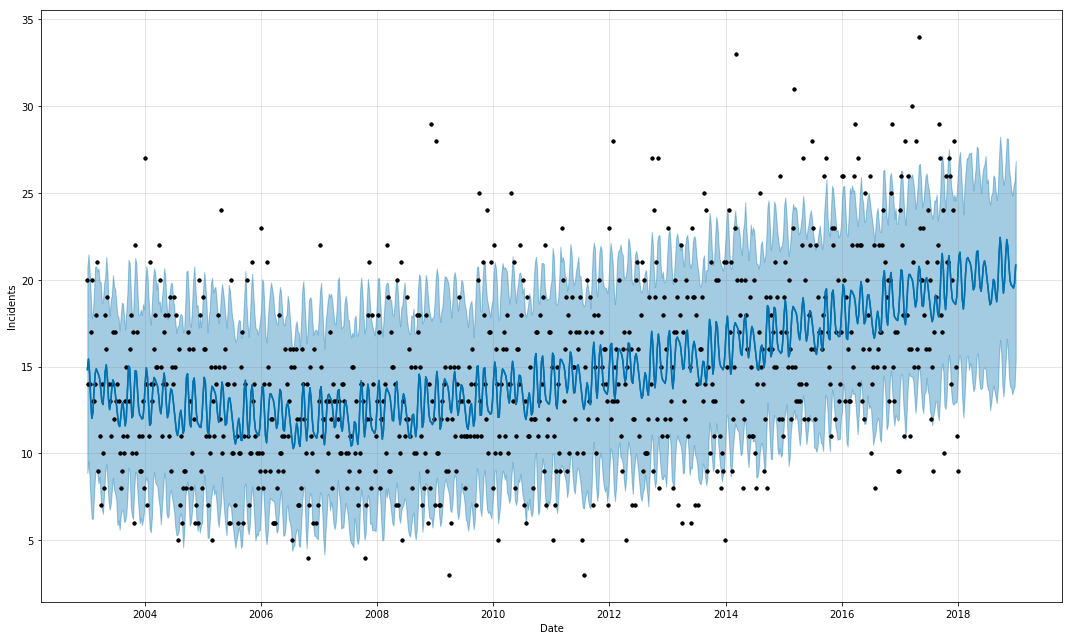

In [250]:
#make graph to show prediction for 2018
model_dict[cat].plot(pred, xlabel = 'Date', ylabel = 'Incidents', ax=ax)
#uncomment below to see zoomed in figure of 2018 prediction
#ax.set_xlim(['2016','2019'])

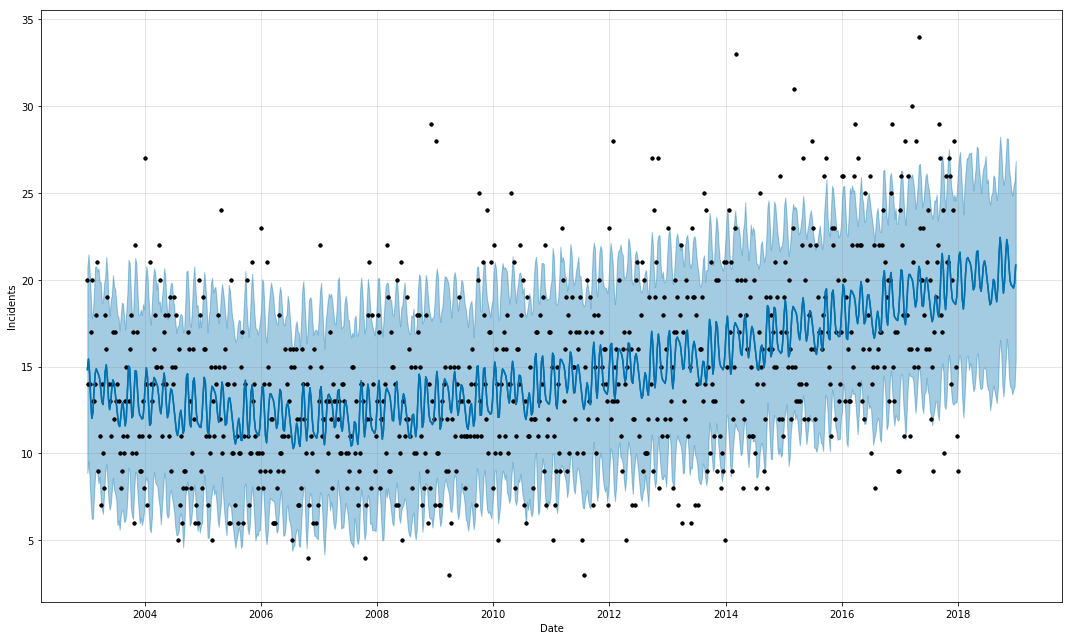

In [251]:
#show 2018 prediction
fig